In [ ]:
!pip install tensorflow

In [ ]:
!pip install xgboost

In [ ]:
!pip install CatBoost

In [ ]:
!pip install lightgbm

In [1]:
#Libraries For Sentiment and Price Comparison
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pandas_datareader import data as pdr
import yfinance as yf
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import random
from math import sqrt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import LSTM
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
import lightgbm as lgb
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

In [2]:
#Importing Sentiments
sentiment_df = pd.read_csv('C:/Dissertation/Datasets/sumscore2.csv')

In [3]:
# Ethereum Price Yahoo Finance 
start_date = '2023-02-28'
end_date = '2023-06-01'
ticker = 'ETH-USD'
yf.pdr_override()
eth = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)
eth

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-28,1634.502441,1644.435791,1602.428101,1605.895142,1605.895142,6323676957
2023-03-01,1606.040405,1663.433716,1601.548584,1663.433716,1663.433716,7701847224
2023-03-02,1663.549072,1672.051147,1622.599976,1647.319336,1647.319336,7080950926
2023-03-03,1647.557739,1648.475342,1552.451538,1569.167603,1569.167603,9922240199
2023-03-04,1569.278076,1575.637207,1551.736816,1566.923950,1566.923950,4389045367
...,...,...,...,...,...,...
2023-05-27,1828.575684,1836.184570,1817.492065,1831.118286,1831.118286,3216737652
2023-05-28,1831.098633,1915.723267,1825.467285,1910.914185,1910.914185,6359610561
2023-05-29,1909.297485,1926.421753,1879.077515,1893.078125,1893.078125,5884674572


In [4]:
#Range of Eth Prices and Sentiments
eth_close_min = eth['Close'].min()
eth_close_max = eth['Close'].max()

print(f'Ethereum Close price range: {eth_close_min} - {eth_close_max}')

sentiment_min = sentiment_df['FinalScore'].min()
sentiment_max = sentiment_df['FinalScore'].max()

print(f'Sentiment FinalScore range: {sentiment_min} - {sentiment_max}')

Ethereum Close price range: 1429.1580810546875 - 2120.005859375
Sentiment FinalScore range: -170.3412244 - -32.84220385


In [5]:
sentiment_df

,Unnamed: 0,Date,FinalScore
0,0,27-02-2023,-56.298266
1,1,28-02-2023,-58.008373
2,2,01-03-2023,-77.803071
3,3,02-03-2023,-76.579328
4,4,03-03-2023,-73.377458
...,...,...,...
89,89,27-05-2023,-66.212404
90,90,28-05-2023,-40.889290
91,91,29-05-2023,-44.392002
92,92,30-05-2023,-63.050229


In [6]:
eth.index = pd.to_datetime(eth.index)
sentiment_df['Date'] = pd.to_datetime(sentiment_df['Date'], format='%d-%m-%Y')
sentiment_df

,Unnamed: 0,Date,FinalScore
0,0,2023-02-27,-56.298266
1,1,2023-02-28,-58.008373
2,2,2023-03-01,-77.803071
3,3,2023-03-02,-76.579328
4,4,2023-03-03,-73.377458
...,...,...,...
89,89,2023-05-27,-66.212404
90,90,2023-05-28,-40.889290
91,91,2023-05-29,-44.392002
92,92,2023-05-30,-63.050229


In [7]:
sentiment_df_2 = sentiment_df
sentiment_df_2

,Unnamed: 0,Date,FinalScore
0,0,2023-02-27,-56.298266
1,1,2023-02-28,-58.008373
2,2,2023-03-01,-77.803071
3,3,2023-03-02,-76.579328
4,4,2023-03-03,-73.377458
...,...,...,...
89,89,2023-05-27,-66.212404
90,90,2023-05-28,-40.889290
91,91,2023-05-29,-44.392002
92,92,2023-05-30,-63.050229


In [8]:
merged_df = pd.merge(eth, sentiment_df, left_index=True, right_on='Date', how='inner')
merged_df

,Open,High,Low,Close,Adj Close,Volume,Unnamed: 0,Date,FinalScore
1,1634.502441,1644.435791,1602.428101,1605.895142,1605.895142,6323676957,1,2023-02-28,-58.008373
2,1606.040405,1663.433716,1601.548584,1663.433716,1663.433716,7701847224,2,2023-03-01,-77.803071
3,1663.549072,1672.051147,1622.599976,1647.319336,1647.319336,7080950926,3,2023-03-02,-76.579328
4,1647.557739,1648.475342,1552.451538,1569.167603,1569.167603,9922240199,4,2023-03-03,-73.377458
5,1569.278076,1575.637207,1551.736816,1566.923950,1566.923950,4389045367,5,2023-03-04,-57.974046
...,...,...,...,...,...,...,...,...,...
89,1828.575684,1836.184570,1817.492065,1831.118286,1831.118286,3216737652,89,2023-05-27,-66.212404
90,1831.098633,1915.723267,1825.467285,1910.914185,1910.914185,6359610561,90,2023-05-28,-40.889290
91,1909.297485,1926.421753,1879.077515,1893.078125,1893.078125,5884674572,91,2023-05-29,-44.392002
92,1893.093140,1916.574951,1883.934692,1901.026611,1901.026611,5363439784,92,2023-05-30,-63.050229


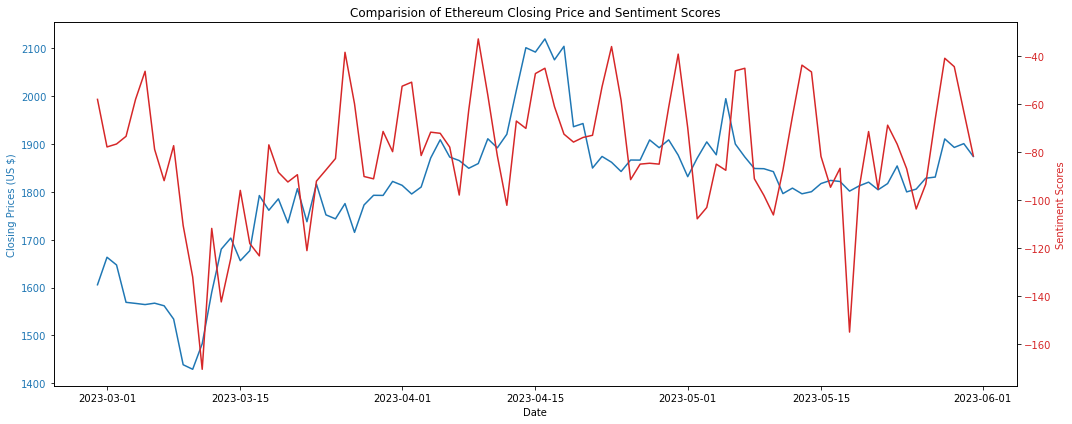

In [9]:
#Time series of Ethereum and Sentiments Comparison
fig, ax1 = plt.subplots(figsize=(15, 6))

#Closing prices
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Closing Prices (US $)', color=color)
ax1.plot(merged_df['Date'], merged_df['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()

#Sentiment scores
color = 'tab:red'
ax2.set_ylabel('Sentiment Scores', color=color)
ax2.plot(merged_df['Date'], merged_df['FinalScore'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Comparision of Ethereum Closing Price and Sentiment Scores')

fig.tight_layout()
plt.show()

Correlation between ETH Close Prices and Sentiment Scores: 0.38034911414725275
P-value: 0.00016942651372449654


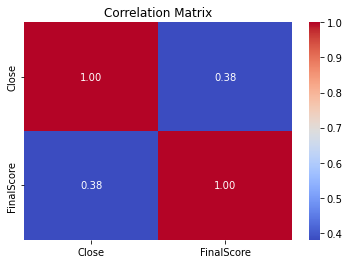

In [10]:
#Correlation - Pearson
merged_df.dropna(inplace=True)

#Correlation matrix
correlation = merged_df[['Close', 'FinalScore']].corr()
correlation_val, p_val = pearsonr(merged_df['Close'], merged_df['FinalScore'])
print("Correlation between ETH Close Prices and Sentiment Scores:", correlation_val)
print("P-value:", p_val)

#Heatmap
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

Spearman Correlation between ETH Close Prices and Sentiment Scores: 0.33850079078511525
Spearman P-value: 0.0009041158436344318


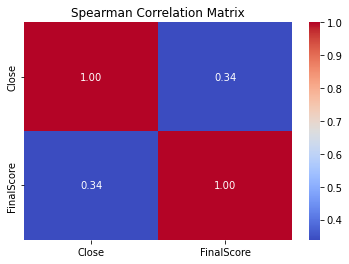

In [11]:
#Correlation - Spearman 
merged_df.dropna(inplace=True)

#Correlation matrix
correlation_spearman, p_val_spearman = spearmanr(merged_df['Close'], merged_df['FinalScore'])

print("Spearman Correlation between ETH Close Prices and Sentiment Scores:", correlation_spearman)
print("Spearman P-value:", p_val_spearman)
correlation_matrix_spearman = merged_df[['Close', 'FinalScore']].corr(method='spearman')

#Heatmap
sns.heatmap(correlation_matrix_spearman, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Spearman Correlation Matrix")
plt.show()

Kendall's tau correlation between ETH Close Prices and Sentiment Scores: 0.2276764843384759
Kendall's tau p-value: 0.0012269741771925259


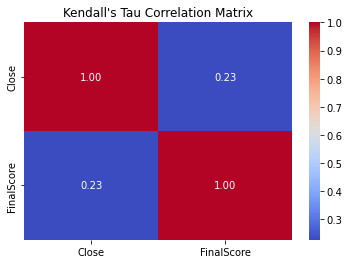

In [12]:
#Correlation - Kendall's Tau
merged_df.dropna(inplace=True)

#Correlation matrix
correlation_kendall = merged_df[['Close', 'FinalScore']].corr(method='kendall')
correlation_val_kendall, p_val_kendall = kendalltau(merged_df['Close'], merged_df['FinalScore'])

print("Kendall's tau correlation between ETH Close Prices and Sentiment Scores:", correlation_val_kendall)
print("Kendall's tau p-value:", p_val_kendall)

#Heatmap
sns.heatmap(correlation_kendall, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Kendall's Tau Correlation Matrix")
plt.show()


In [13]:
#Granger causality test
gc_res = grangercausalitytests(merged_df[['Close', 'FinalScore']], maxlag=1, verbose=False)

p_value_price_sentiment = gc_res[1][0]['ssr_ftest'][1]
p_value_sentiment_price = gc_res[1][0]['ssr_chi2test'][1]

print('P-value of ETH Close Prices causing Sentiment Score:', p_value_price_sentiment)
if p_value_price_sentiment <= 0.05:
    print("Strong evidence against the null hypothesis, reject the null hypothesis. There is a Granger causality from ETH Close Prices to Sentiment Scores.")
else:
    print("Weak evidence against the null hypothesis, fail to reject the null hypothesis. There is no Granger causality from ETH Close Prices to Sentiment Scores.")

print('P-value of Sentiment Score causing ETH Close Prices:', p_value_sentiment_price)
if p_value_sentiment_price <= 0.05:
    print("Strong evidence against the null hypothesis, reject the null hypothesis. There is a Granger causality from Sentiment Scores to ETH Close Prices.")
else:
    print("Weak evidence against the null hypothesis, fail to reject the null hypothesis. There is no Granger causality from Sentiment Scores to ETH Close Prices.")

P-value of ETH Close Prices causing Sentiment Score: 0.13938419898610874
Weak evidence against the null hypothesis, fail to reject the null hypothesis. There is no Granger causality from ETH Close Prices to Sentiment Scores.
P-value of Sentiment Score causing ETH Close Prices: 0.12942833067070894
Weak evidence against the null hypothesis, fail to reject the null hypothesis. There is no Granger causality from Sentiment Scores to ETH Close Prices.


In [14]:
#Checking Correlation of Sentiments by lag
sentiment_df= sentiment_df[(sentiment_df['Date'] >='2023-02-28')&(sentiment_df['Date'] <='2023-05-31')]

#Range of lags
min_lag = 1
max_lag = 20

#Correlations
correlations = []
for lag in range(min_lag, max_lag + 1):
    lagged_sentiment_scores = sentiment_df['FinalScore'][:-lag]
    lagged_closing_prices = eth['Close'][lag:]

    correlation, _ = pearsonr(lagged_closing_prices, lagged_sentiment_scores)
    correlations.append(correlation)

for lag, correlation in zip(range(min_lag, max_lag + 1), correlations):
    print(f"Correlation for lag {lag}: {correlation}")

Correlation for lag 1: 0.30700400566577174
Correlation for lag 2: 0.2523862419905772
Correlation for lag 3: 0.21187950394453095
Correlation for lag 4: 0.1723614993171833
Correlation for lag 5: 0.18103710479129054
Correlation for lag 6: 0.13597919100692568
Correlation for lag 7: 0.11092031808375284
Correlation for lag 8: 0.13003131293845785
Correlation for lag 9: 0.16982890994150573
Correlation for lag 10: 0.12436760681478631
Correlation for lag 11: 0.1653167396206304
Correlation for lag 12: 0.1939752248680676
Correlation for lag 13: 0.23653697197825846
Correlation for lag 14: 0.27014492289854103
Correlation for lag 15: 0.24076296305739447
Correlation for lag 16: 0.27112375924691356
Correlation for lag 17: 0.24086402277300176
Correlation for lag 18: 0.17771970904389833
Correlation for lag 19: 0.13964915849763612
Correlation for lag 20: 0.06752688434634242


In [15]:
#Preparing Train and Test Data
sentiment_df_2= sentiment_df_2[(sentiment_df_2['Date'] >='2023-02-28')&(sentiment_df_2['Date'] <='2023-05-31')]
sentiment_df_2 = sentiment_df_2.drop('Unnamed: 0', axis=1)
sentiment_df_2

,Date,FinalScore
1,2023-02-28,-58.008373
2,2023-03-01,-77.803071
3,2023-03-02,-76.579328
4,2023-03-03,-73.377458
5,2023-03-04,-57.974046
...,...,...
89,2023-05-27,-66.212404
90,2023-05-28,-40.889290
91,2023-05-29,-44.392002
92,2023-05-30,-63.050229


In [16]:
sentiment_df_2['Lagged_score'] = sentiment_df_2['FinalScore'].shift(1)
sentiment_df_2 = sentiment_df_2.drop(sentiment_df_2.index[0])
sentiment_df_2= sentiment_df_2.reset_index()
sentiment_df_2 = sentiment_df_2.drop('index', axis=1)
sentiment_df_2

,Date,FinalScore,Lagged_score
0,2023-03-01,-77.803071,-58.008373
1,2023-03-02,-76.579328,-77.803071
2,2023-03-03,-73.377458,-76.579328
3,2023-03-04,-57.974046,-73.377458
4,2023-03-05,-46.310909,-57.974046
...,...,...,...
87,2023-05-27,-66.212404,-93.328212
88,2023-05-28,-40.889290,-66.212404
89,2023-05-29,-44.392002,-40.889290
90,2023-05-30,-63.050229,-44.392002


In [17]:
# Merging the extracted columns into a new dataframe
merged_df_2 = pd.merge(eth, sentiment_df_2, left_index=True, right_on='Date', how='inner')
merged_df_2

,Open,High,Low,Close,Adj Close,Volume,Date,FinalScore,Lagged_score
0,1606.040405,1663.433716,1601.548584,1663.433716,1663.433716,7701847224,2023-03-01,-77.803071,-58.008373
1,1663.549072,1672.051147,1622.599976,1647.319336,1647.319336,7080950926,2023-03-02,-76.579328,-77.803071
2,1647.557739,1648.475342,1552.451538,1569.167603,1569.167603,9922240199,2023-03-03,-73.377458,-76.579328
3,1569.278076,1575.637207,1551.736816,1566.923950,1566.923950,4389045367,2023-03-04,-57.974046,-73.377458
4,1567.179321,1584.208862,1559.954102,1564.468750,1564.468750,5020886238,2023-03-05,-46.310909,-57.974046
...,...,...,...,...,...,...,...,...,...
87,1828.575684,1836.184570,1817.492065,1831.118286,1831.118286,3216737652,2023-05-27,-66.212404,-93.328212
88,1831.098633,1915.723267,1825.467285,1910.914185,1910.914185,6359610561,2023-05-28,-40.889290,-66.212404
89,1909.297485,1926.421753,1879.077515,1893.078125,1893.078125,5884674572,2023-05-29,-44.392002,-40.889290
90,1893.093140,1916.574951,1883.934692,1901.026611,1901.026611,5363439784,2023-05-30,-63.050229,-44.392002


In [18]:
#Extracting Relevant Columns
merged_df_2= merged_df_2[['Date','Close','Lagged_score','FinalScore']]
merged_df_2

,Date,Close,Lagged_score,FinalScore
0,2023-03-01,1663.433716,-58.008373,-77.803071
1,2023-03-02,1647.319336,-77.803071,-76.579328
2,2023-03-03,1569.167603,-76.579328,-73.377458
3,2023-03-04,1566.923950,-73.377458,-57.974046
4,2023-03-05,1564.468750,-57.974046,-46.310909
...,...,...,...,...
87,2023-05-27,1831.118286,-93.328212,-66.212404
88,2023-05-28,1910.914185,-66.212404,-40.889290
89,2023-05-29,1893.078125,-40.889290,-44.392002
90,2023-05-30,1901.026611,-44.392002,-63.050229


In [19]:
#Fitting Models
def calculate_mape(y_true, y_pred):
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return "{:.2f}%".format(mape)

In [20]:
#XGBoost with Hyperparameter Tuning

#One day lagged
merged_df_2['Lagged_closing_price'] = merged_df_2['Close'].shift(1)
merged_df_2 = merged_df_2.dropna()

#Features
X = merged_df_2[['Lagged_score', 'Lagged_closing_price']]
y = merged_df_2['Close']

train_size = int(0.8 * len(merged_df_2)) 
X_train= X[:train_size]
X_test= X[train_size:]
y_train= y[:train_size]
y_test= y[train_size:]

#hyperparameters to be tuned
param_dist = {
    'n_estimators': [10, 30, 50, 100, 150, 200, 300, 500],
    'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 12],
    'learning_rate': [0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.5, 1],
    'min_child_weight': [1, 2, 3, 4, 5, 6]
}

xgb_reg = xgb.XGBRegressor(seed=12)
random_search = RandomizedSearchCV(xgb_reg, param_distributions=param_dist, n_iter=100,
                                   scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1, random_state=42)


#Fit the model
random_search.fit(X_train, y_train)

#Finding the best estimator and predict on the test set
best_xgb_reg = random_search.best_estimator_

y_pred = best_xgb_reg.predict(X_test)

#Evaluation metrics
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape_test = calculate_mape(y_test, y_pred)
print(f'Best Parameters: {random_search.best_params_}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error: {mape_test}')

C:\Users\felix\AppData\Local\Temp\ipykernel_19812\3120596969.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_2['Lagged_closing_price'] = merged_df_2['Close'].shift(1)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'subsample': 0.6, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.25, 'gamma': 0, 'colsample_bytree': 1.0}
Root Mean Squared Error: 36.32655183071469
Mean Absolute Error: 29.19332725123355
Mean Absolute Percentage Error: 1.59%


In [21]:

X_test['Date'] = merged_df_2['Date'].iloc[len(y_train):].values
XGB_result_df = pd.DataFrame({'Date': X_test['Date'].values, 'Close': y_test.values, 'Predicted_Ethereum_Price': y_pred})

XGB_result_df['Actual_Direction'] = np.where(XGB_result_df['Close'] > XGB_result_df['Close'].shift(1), 'Up', 'Down')
XGB_result_df['Predicted_Direction'] = np.where(XGB_result_df['Predicted_Ethereum_Price'] > XGB_result_df['Predicted_Ethereum_Price'].shift(1), 'Up', 'Down')
print(XGB_result_df.head())


matches = XGB_result_df['Actual_Direction'] == XGB_result_df['Predicted_Direction']
accuracy = (matches.sum() / len(matches)) * 100
print(f'Accuracy: {accuracy}%')

        Date        Close  Predicted_Ethereum_Price Actual_Direction  \
0 2023-05-13  1796.114868               1799.776489             Down   
1 2023-05-14  1800.500977               1804.493286               Up   
2 2023-05-15  1817.549927               1819.465454               Up   
3 2023-05-16  1824.121460               1827.547852               Up   
4 2023-05-17  1821.859619               1787.281494             Down   

  Predicted_Direction  
0                Down  
1                  Up  
2                  Up  
3                  Up  
4                Down  
Accuracy: 63.1578947368421%


C:\Users\felix\AppData\Local\Temp\ipykernel_19812\1207420395.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Date'] = merged_df_2['Date'].iloc[len(y_train):].values


In [22]:
XGB_result_df.to_csv("C:/Dissertation/ML Codes Final/ML Output/eth_op.csv")

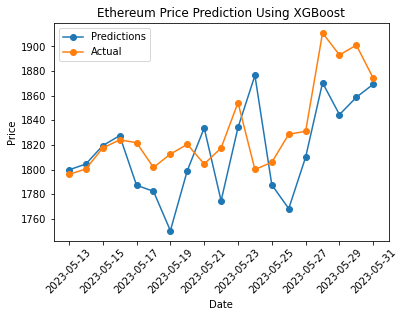

In [23]:

predictions = XGB_result_df['Predicted_Ethereum_Price']
actual_values = XGB_result_df['Close']

# Plotting the line graph
plt.plot(XGB_result_df['Date'], predictions, marker='o', label='Predictions')
plt.plot(XGB_result_df['Date'], actual_values, marker='o', label='Actual')

plt.title('Ethereum Price Prediction Using XGBoost')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)

plt.legend()

# Displaying the plot
plt.show()

In [24]:
#Gated Reccurrent Unit

np.random.seed(44)
tf.random.set_seed(44)
random.seed(44)

# Scaling the input features
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(merged_df_2[['Lagged_score', 'Lagged_closing_price']])
target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(merged_df_2[['Close']])

X = X_scaled
y = y_scaled

#Splitting the dataset into the Training set and Test set sequentially
split_ratio = 0.8
split_idx = int(split_ratio * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

#Building the GRU model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(units=50))
model.add(Dense(1))

#Compiling the GRU
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=50, batch_size=64)

y_pred = model.predict(X_test)


y_test_original = target_scaler.inverse_transform(y_test)
y_pred_original = target_scaler.inverse_transform(y_pred)


rmse = sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)
mape_test = calculate_mape(y_test, y_pred)
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error: {mape_test}')

Epoch 1/50
2/2 [==============================] - 4s 21ms/step - loss: 0.3143
Epoch 2/50
2/2 [==============================] - 0s 8ms/step - loss: 0.2682
Epoch 3/50
2/2 [==============================] - 0s 7ms/step - loss: 0.2267
Epoch 4/50
2/2 [==============================] - 0s 4ms/step - loss: 0.1882
Epoch 5/50
2/2 [==============================] - 0s 12ms/step - loss: 0.1538
Epoch 6/50
2/2 [==============================] - 0s 8ms/step - loss: 0.1215
Epoch 7/50
2/2 [==============================] - 0s 3ms/step - loss: 0.0945
Epoch 8/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0715
Epoch 9/50
2/2 [==============================] - 0s 6ms/step - loss: 0.0532
Epoch 10/50
2/2 [==============================] - 0s 7ms/step - loss: 0.0401
Epoch 11/50
2/2 [==============================] - 0s 2ms/step - loss: 0.0331
Epoch 12/50
2/2 [==============================] - 0s 5ms/step - loss: 0.0302
Epoch 13/50
2/2 [==============================] - 0s 8ms/step - loss: 

In [25]:

y_test = pd.DataFrame(y_test_original, columns=['Values'])
y_pred= pd.DataFrame(y_pred_original, columns=['Values'])

In [26]:
GRU_result_df = pd.DataFrame({'Date':merged_df_2['Date'].iloc[len(y_train):].values , 'Close': y_test['Values'].values, 'Predicted_Ethereum_Price': y_pred['Values'].values})

GRU_result_df['Actual_Direction'] = np.where(GRU_result_df['Close'] > GRU_result_df['Close'].shift(1), 'Up', 'Down')
GRU_result_df['Predicted_Direction'] = np.where(GRU_result_df['Predicted_Ethereum_Price'] > GRU_result_df['Predicted_Ethereum_Price'].shift(1), 'Up', 'Down')
print(GRU_result_df.head())

matches_test = GRU_result_df['Actual_Direction'] == GRU_result_df['Predicted_Direction']
accuracy_test = (matches_test.sum() / len(matches_test)) * 100
print(f'Accuracy for Test Data: {accuracy_test}%')

        Date        Close  Predicted_Ethereum_Price Actual_Direction  \
0 2023-05-13  1796.114868               1836.508545             Down   
1 2023-05-14  1800.500977               1846.487549               Up   
2 2023-05-15  1817.549927               1846.706787               Up   
3 2023-05-16  1824.121460               1828.606934               Up   
4 2023-05-17  1821.859619               1821.942017             Down   

  Predicted_Direction  
0                Down  
1                  Up  
2                  Up  
3                Down  
4                Down  
Accuracy for Test Data: 47.368421052631575%


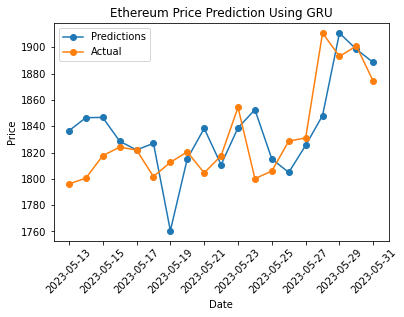

In [27]:
predictions = GRU_result_df['Predicted_Ethereum_Price']
actual_values = GRU_result_df['Close']

plt.plot(GRU_result_df['Date'], predictions, marker='o', label='Predictions')
plt.plot(GRU_result_df['Date'], actual_values, marker='o', label='Actual')


plt.title('Ethereum Price Prediction Using GRU')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)

plt.legend()

plt.show()

In [28]:
#Holt's Winter
np.random.seed(0)
X = merged_df_2[['Lagged_score', 'Lagged_closing_price']]
y = merged_df_2['Close']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


seasonal_periods = [2,4,6,8,10,12,14,16,18,20,22,24,26,28,30] 

best_model = None
best_rmse = float('inf')

# Perform grid search
for period in seasonal_periods:
    model = ExponentialSmoothing(y_train, seasonal='add', seasonal_periods=period)
    model_fit = model.fit()

    y_pred = model_fit.predict(start=X_test.index[0], end=X_test.index[-1])

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model_fit
        best_seasonal_period = period

# Print the best seasonal period and RMSE
print("Best Seasonal Period:", best_seasonal_period)
print("Best RMSE:", best_rmse)


C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index

Best Seasonal Period: 8
Best RMSE: 43.80116496362946


C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [29]:
#Holtz Winter
np.random.seed(0)
X = merged_df_2[['Lagged_score', 'Lagged_closing_price']]
y = merged_df_2['Close']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


model = ExponentialSmoothing(y_train, seasonal='add', seasonal_periods=8)
model_fit = model.fit()


y_pred = model_fit.forecast(len(y_test))

rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape_test = calculate_mape(y_test, y_pred)
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error: {mape_test}')

Root Mean Squared Error: 46.313489466988464
Mean Absolute Error: 31.18755930821489
Mean Absolute Percentage Error: 1.44%


C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\felix\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [30]:

HW_result_df = pd.DataFrame({
    'Date': merged_df_2['Date'].iloc[len(y_train):],
    'Close': y_test.values,
    'Predicted_Ethereum_Price': y_pred.values
})

HW_result_df['Actual_Direction'] = np.where(HW_result_df['Close'] > HW_result_df['Close'].shift(1), 'Up', 'Down')
HW_result_df['Predicted_Direction'] = np.where(HW_result_df['Predicted_Ethereum_Price'] > HW_result_df['Predicted_Ethereum_Price'].shift(1), 'Up', 'Down')

print(HW_result_df)


matches = HW_result_df['Actual_Direction'] == HW_result_df['Predicted_Direction']

accuracy = (matches.sum() / len(matches)) * 100
print(f'Accuracy for Test Data: {accuracy}%')

         Date        Close  Predicted_Ethereum_Price Actual_Direction  \
73 2023-05-13  1796.114868               1803.041118             Down   
74 2023-05-14  1800.500977               1792.330138               Up   
75 2023-05-15  1817.549927               1805.528133               Up   
76 2023-05-16  1824.121460               1825.547077               Up   
77 2023-05-17  1821.859619               1810.289099             Down   
78 2023-05-18  1801.728516               1816.945110             Down   
79 2023-05-19  1812.589478               1803.468198               Up   
80 2023-05-20  1820.478027               1807.670923               Up   
81 2023-05-21  1804.531372               1803.041118             Down   
82 2023-05-22  1817.534790               1792.330138               Up   
83 2023-05-23  1854.380615               1805.528133               Up   
84 2023-05-24  1800.099976               1825.547077             Down   
85 2023-05-25  1805.953735               1810.28909

In [31]:
HW_result_df.to_csv("C:/Dissertation/ML Codes Final/ML Output/eth_hw.csv")

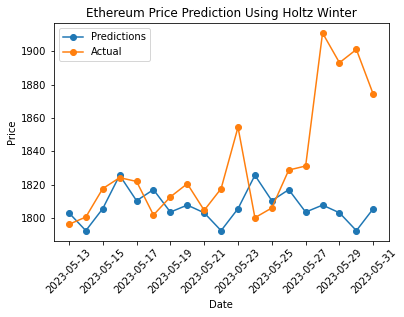

In [32]:
predictions = HW_result_df['Predicted_Ethereum_Price']
actual_values = HW_result_df['Close']

plt.plot(HW_result_df['Date'], predictions, marker='o', label='Predictions')
plt.plot(HW_result_df['Date'], actual_values, marker='o', label='Actual')

plt.title('Ethereum Price Prediction Using Holtz Winter')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)

plt.legend()

plt.show()

In [33]:
#SVR- Support Vector Regression

X = merged_df_2[['Lagged_closing_price', 'Lagged_score']].values
y = merged_df_2['Close'].values.reshape(-1, 1)

scaler_X = MinMaxScaler(feature_range=(0, 1))
X = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = SVR(kernel='rbf', C=1e2, gamma=0.1)

#Fit the model
model.fit(X_train, y_train.ravel())

train_predict = model.predict(X_train).reshape(-1, 1)
test_predict = model.predict(X_test).reshape(-1, 1)

train_predict = scaler_y.inverse_transform(train_predict)
y_train = scaler_y.inverse_transform(y_train)
test_predict = scaler_y.inverse_transform(test_predict)
y_test = scaler_y.inverse_transform(y_test)


rmse_train = sqrt(mean_squared_error(y_train, train_predict))
mae_train = mean_absolute_error(y_train, train_predict)
rmse_test = sqrt(mean_squared_error(y_test, test_predict))
mae_test = mean_absolute_error(y_test, test_predict)
mape_test = calculate_mape(y_test, test_predict)
print(f'Root Mean Squared Error: {rmse_test}')
print(f'Mean Absolute Error: {mae_test}')
print(f'Mean Absolute Percentage Error: {mape_test}')

Root Mean Squared Error: 29.129020807900652
Mean Absolute Error: 20.14697144700839
Mean Absolute Percentage Error: 1.09%


In [34]:
SVR_result_df = pd.DataFrame({
    'Date': merged_df_2['Date'].iloc[len(y_train):].values,
    'Close': y_test.flatten(),
    'Predicted_Ethereum_Price': test_predict.flatten()
})


SVR_result_df['Actual_Direction'] = np.where(SVR_result_df['Close'] > SVR_result_df['Close'].shift(1), 'Up', 'Down')
SVR_result_df['Predicted_Direction'] = np.where(SVR_result_df['Predicted_Ethereum_Price'] > SVR_result_df['Predicted_Ethereum_Price'].shift(1), 'Up', 'Down')

print(SVR_result_df.head())

matches = SVR_result_df['Actual_Direction'] == SVR_result_df['Predicted_Direction']
accuracy = (matches.sum() / len(matches)) * 100
print(f'Accuracy: {accuracy}%')

        Date        Close  Predicted_Ethereum_Price Actual_Direction  \
0 2023-05-13  1796.114868               1801.947677             Down   
1 2023-05-14  1800.500977               1783.994067               Up   
2 2023-05-15  1817.549927               1789.177608               Up   
3 2023-05-16  1824.121460               1817.726099               Up   
4 2023-05-17  1821.859619               1829.995841             Down   

  Predicted_Direction  
0                Down  
1                Down  
2                  Up  
3                  Up  
4                  Up  
Accuracy: 47.368421052631575%


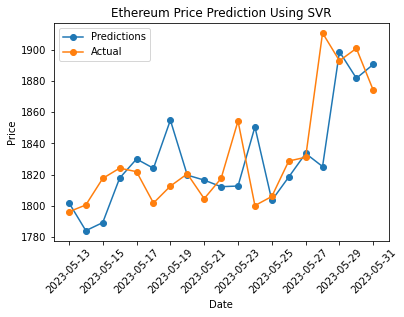

In [35]:
predictions = SVR_result_df['Predicted_Ethereum_Price']
actual_values = SVR_result_df['Close']

plt.plot(SVR_result_df['Date'], predictions, marker='o', label='Predictions')
plt.plot(SVR_result_df['Date'], actual_values, marker='o', label='Actual')

plt.title('Ethereum Price Prediction Using SVR')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)

plt.legend()

plt.show()

In [36]:
#LightGBM

#Features
X = merged_df_2[['Lagged_closing_price', 'Lagged_score']].values
y = merged_df_2['Close'].values.reshape(-1, 1)

scaler_X = MinMaxScaler(feature_range=(0, 1))
X = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler_y.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

#Building LightGBM Model
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

lgb_train = lgb.Dataset(X_train, y_train.ravel())
lgb_eval = lgb.Dataset(X_test, y_test.ravel(), reference=lgb_train)

model = lgb.train(params, lgb_train, num_boost_round=1000, valid_sets=lgb_eval, early_stopping_rounds=10, verbose_eval=200)

train_predict = model.predict(X_train, num_iteration=model.best_iteration).reshape(-1, 1)
test_predict = model.predict(X_test, num_iteration=model.best_iteration).reshape(-1, 1)

train_predict = scaler_y.inverse_transform(train_predict)
y_train = scaler_y.inverse_transform(y_train)
test_predict = scaler_y.inverse_transform(test_predict)
y_test = scaler_y.inverse_transform(y_test)

#Evaluation metrics
rmse_train = sqrt(mean_squared_error(y_train, train_predict))
mae_train = mean_absolute_error(y_train, train_predict)
rmse_test = sqrt(mean_squared_error(y_test, test_predict))
mae_test = mean_absolute_error(y_test, test_predict)
mape_test = calculate_mape(y_test, test_predict)
print(f'Root Mean Squared Error: {rmse_test}')
print(f'Mean Absolute Error: {mae_test}')
print(f'Mean Absolute Percentage Error: {mape_test}')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 50
[LightGBM] [Info] Number of data points in the train set: 72, number of used features: 2
[LightGBM] [Info] Start training from score 0.548427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

C:\Users\felix\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\felix\anaconda3\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


In [37]:
LightGBM_result_df = pd.DataFrame({
    'Date': merged_df_2['Date'].iloc[len(y_train):].values,
    'Close': y_test.flatten(),
    'Predicted_Ethereum_Price': test_predict.flatten()
})

LightGBM_result_df['Actual_Direction'] = np.where(LightGBM_result_df['Close'] > 
                                                  LightGBM_result_df['Close'].shift(1), 'Up', 'Down')
LightGBM_result_df['Predicted_Direction'] = np.where(LightGBM_result_df['Predicted_Ethereum_Price'] > 
                                                     LightGBM_result_df['Predicted_Ethereum_Price'].shift(1), 'Up', 'Down')
print(LightGBM_result_df.head())

matches = LightGBM_result_df['Actual_Direction'] == LightGBM_result_df['Predicted_Direction']
accuracy = (matches.sum() / len(matches)) * 100
print(f'Accuracy: {accuracy}%')

        Date        Close  Predicted_Ethereum_Price Actual_Direction  \
0 2023-05-13  1796.114868               1801.359741             Down   
1 2023-05-14  1800.500977               1801.359741               Up   
2 2023-05-15  1817.549927               1801.359741               Up   
3 2023-05-16  1824.121460               1814.016105               Up   
4 2023-05-17  1821.859619               1829.903679             Down   

  Predicted_Direction  
0                Down  
1                Down  
2                Down  
3                  Up  
4                  Up  
Accuracy: 36.84210526315789%


In [38]:
#Long Short Term Memory
np.random.seed(44) 
tf.random.set_seed(44)

X = merged_df_2[['Lagged_closing_price', 'Lagged_score']].values
y = merged_df_2['Close'].values.reshape(-1, 1)


scaler_X = MinMaxScaler(feature_range=(0, 1))
X = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

#Building LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1, 2)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler_y.inverse_transform(train_predict)
y_train = scaler_y.inverse_transform(y_train)
test_predict = scaler_y.inverse_transform(test_predict)
y_test = scaler_y.inverse_transform(y_test)


rmse_train = sqrt(mean_squared_error(y_train, train_predict))
mae_train = mean_absolute_error(y_train, train_predict)
rmse_test = sqrt(mean_squared_error(y_test, test_predict))
mae_test = mean_absolute_error(y_test, test_predict)
mape_test = calculate_mape(y_test, test_predict)
print(f'Root Mean Squared Error: {rmse_test}')
print(f'Mean Absolute Error: {mae_test}')
print(f'Mean Absolute Percentage Error: {mape_test}')

Epoch 1/50
2/2 [==============================] - 5s 25ms/step - loss: 0.3481
Epoch 2/50
2/2 [==============================] - 0s 6ms/step - loss: 0.3352
Epoch 3/50
2/2 [==============================] - 0s 5ms/step - loss: 0.3228
Epoch 4/50
2/2 [==============================] - 0s 5ms/step - loss: 0.3102
Epoch 5/50
2/2 [==============================] - 0s 8ms/step - loss: 0.2978
Epoch 6/50
2/2 [==============================] - 0s 7ms/step - loss: 0.2848
Epoch 7/50
2/2 [==============================] - 0s 8ms/step - loss: 0.2721
Epoch 8/50
2/2 [==============================] - 0s 8ms/step - loss: 0.2590
Epoch 9/50
2/2 [==============================] - 0s 12ms/step - loss: 0.2456
Epoch 10/50
2/2 [==============================] - 0s 10ms/step - loss: 0.2317
Epoch 11/50
2/2 [==============================] - 0s 10ms/step - loss: 0.2179
Epoch 12/50
2/2 [==============================] - 0s 9ms/step - loss: 0.2033
Epoch 13/50
2/2 [==============================] - 0s 9ms/step - loss

In [39]:
LSTM_result_df = pd.DataFrame({
    'Date': merged_df_2['Date'].iloc[len(y_train):].values,
    'Close': y_test.flatten(),
    'Predicted_Ethereum_Price': test_predict.flatten()
})


LSTM_result_df['Actual_Direction'] = np.where(LSTM_result_df['Close'] > LSTM_result_df['Close'].shift(1), 'Up', 'Down')
LSTM_result_df['Predicted_Direction'] = np.where(LSTM_result_df['Predicted_Ethereum_Price'] > LSTM_result_df['Predicted_Ethereum_Price'].shift(1), 'Up', 'Down')
print(LSTM_result_df.head())

matches = LSTM_result_df['Actual_Direction'] == LSTM_result_df['Predicted_Direction']
accuracy = (matches.sum() / len(matches)) * 100
print(f'Accuracy: {accuracy}%')

        Date        Close  Predicted_Ethereum_Price Actual_Direction  \
0 2023-05-13  1796.114868               1839.520996             Down   
1 2023-05-14  1800.500977               1866.379150               Up   
2 2023-05-15  1817.549927               1863.668823               Up   
3 2023-05-16  1824.121460               1818.878906               Up   
4 2023-05-17  1821.859619               1802.876709             Down   

  Predicted_Direction  
0                Down  
1                  Up  
2                Down  
3                Down  
4                Down  
Accuracy: 47.368421052631575%


In [40]:
LSTM_result_df.to_csv("C:/Dissertation/ML Codes Final/ML Output/eth_lstm.csv")

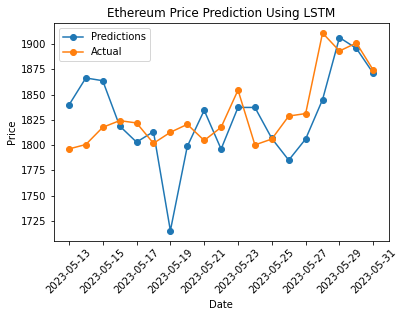

In [41]:
predictions = LSTM_result_df['Predicted_Ethereum_Price']
actual_values = LSTM_result_df['Close']

# Plotting the line graph
plt.plot(LSTM_result_df['Date'], predictions, marker='o', label='Predictions')
plt.plot(LSTM_result_df['Date'], actual_values, marker='o', label='Actual')

plt.title('Ethereum Price Prediction Using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)

plt.legend()

plt.show()

In [42]:
#Bidirectional Long Short Term Memory
np.random.seed(44) 
tf.random.set_seed(44)

X = merged_df_2[['Lagged_closing_price', 'Lagged_score']].values
y = merged_df_2['Close'].values.reshape(-1, 1)

#Scaling
scaler_X = MinMaxScaler(feature_range=(0, 1))
X = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler_y.fit_transform(y)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

#Building LSTM Model
model = Sequential()

model.add(Bidirectional(LSTM(100, activation='relu'), input_shape=(1, 2))) 
model.add(Dense(1))


model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=1)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

train_predict = scaler_y.inverse_transform(train_predict)
y_train = scaler_y.inverse_transform(y_train)
test_predict = scaler_y.inverse_transform(test_predict)
y_test = scaler_y.inverse_transform(y_test)


rmse_train = sqrt(mean_squared_error(y_train, train_predict))
mae_train = mean_absolute_error(y_train, train_predict)
rmse_test = sqrt(mean_squared_error(y_test, test_predict))
mae_test = mean_absolute_error(y_test, test_predict)
mape_test = calculate_mape(y_test, test_predict)
print(f'Root Mean Squared Error: {rmse_test}')
print(f'Mean Absolute Error: {mae_test}')
print(f'Mean Absolute Percentage Error: {mape_test}')

Epoch 1/50
2/2 [==============================] - 4s 15ms/step - loss: 0.3887
Epoch 2/50
2/2 [==============================] - 0s 8ms/step - loss: 0.3719
Epoch 3/50
2/2 [==============================] - 0s 4ms/step - loss: 0.3559
Epoch 4/50
2/2 [==============================] - 0s 5ms/step - loss: 0.3403
Epoch 5/50
2/2 [==============================] - 0s 7ms/step - loss: 0.3254
Epoch 6/50
2/2 [==============================] - 0s 4ms/step - loss: 0.3103
Epoch 7/50
2/2 [==============================] - 0s 7ms/step - loss: 0.2961
Epoch 8/50
2/2 [==============================] - 0s 0s/step - loss: 0.2820
Epoch 9/50
2/2 [==============================] - 0s 5ms/step - loss: 0.2682
Epoch 10/50
2/2 [==============================] - 0s 5ms/step - loss: 0.2546
Epoch 11/50
2/2 [==============================] - 0s 6ms/step - loss: 0.2416
Epoch 12/50
2/2 [==============================] - 0s 609us/step - loss: 0.2283
Epoch 13/50
2/2 [==============================] - 0s 5ms/step - loss: 

In [43]:
BiLSTM_result_df = pd.DataFrame({
    'Date': merged_df_2['Date'].iloc[len(y_train):].values,
    'Close': y_test.flatten(),
    'Predicted_Ethereum_Price': test_predict.flatten()
})

BiLSTM_result_df['Actual_Direction'] = np.where(BiLSTM_result_df['Close'] > BiLSTM_result_df['Close'].shift(1), 'Up', 'Down')
BiLSTM_result_df['Predicted_Direction'] = np.where(BiLSTM_result_df['Predicted_Ethereum_Price'] > BiLSTM_result_df['Predicted_Ethereum_Price'].shift(1), 'Up', 'Down')
print(BiLSTM_result_df.head())

matches = BiLSTM_result_df['Actual_Direction'] == BiLSTM_result_df['Predicted_Direction']
accuracy = (matches.sum() / len(matches)) * 100
print(f'Accuracy: {accuracy}%')

        Date        Close  Predicted_Ethereum_Price Actual_Direction  \
0 2023-05-13  1796.114868               1840.597412             Down   
1 2023-05-14  1800.500977               1859.737305               Up   
2 2023-05-15  1817.549927               1858.324097               Up   
3 2023-05-16  1824.121460               1824.692261               Up   
4 2023-05-17  1821.859619               1811.571655             Down   

  Predicted_Direction  
0                Down  
1                  Up  
2                Down  
3                Down  
4                Down  
Accuracy: 42.10526315789473%


In [44]:
#XGBoost with Hyperparameter Tuning- with only lagged closing price

#One day lagged closing price column
merged_df_2['Lagged_closing_price'] = merged_df_2['Close'].shift(1)
merged_df_2 = merged_df_2.dropna()

#Features
X = merged_df_2[['Lagged_closing_price']]
y = merged_df_2['Close']

train_size = int(0.8 * len(merged_df_2)) 
X_train= X[:train_size]
X_test= X[train_size:]
y_train= y[:train_size]
y_test= y[train_size:]

# Define the hyperparameters
hyperparameters = {
    'n_estimators': 500,
    'max_depth': 3,
    'learning_rate': 0.25,
    'subsample': 0.6,
    'colsample_bytree': 1.0,
    'gamma': 0,
    'min_child_weight': 1
}


xgb_reg = xgb.XGBRegressor(**hyperparameters, seed=12)

# Fit the model
xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_test)


rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape_test = calculate_mape(y_test, y_pred)

print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Absolute Percentage Error: {mape_test}')

Root Mean Squared Error: 51.62745768292569
Mean Absolute Error: 37.18236626519097
Mean Absolute Percentage Error: 2.03%


C:\Users\felix\AppData\Local\Temp\ipykernel_19812\781630619.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_2['Lagged_closing_price'] = merged_df_2['Close'].shift(1)


In [45]:

X_test['Date'] = merged_df_2['Date'].iloc[len(y_train):].values
XGB_result_df = pd.DataFrame({'Date': X_test['Date'].values, 'Close': y_test.values, 'Predicted_Ethereum_Price': y_pred})

XGB_result_df['Actual_Direction'] = np.where(XGB_result_df['Close'] > XGB_result_df['Close'].shift(1), 'Up', 'Down')
XGB_result_df['Predicted_Direction'] = np.where(XGB_result_df['Predicted_Ethereum_Price'] > XGB_result_df['Predicted_Ethereum_Price'].shift(1), 'Up', 'Down')
print(XGB_result_df.head())

matches = XGB_result_df['Actual_Direction'] == XGB_result_df['Predicted_Direction']
accuracy = (matches.sum() / len(matches)) * 100
print(f'Accuracy: {accuracy}%')

        Date        Close  Predicted_Ethereum_Price Actual_Direction  \
0 2023-05-14  1800.500977               1808.105713             Down   
1 2023-05-15  1817.549927               1800.845215               Up   
2 2023-05-16  1824.121460               1752.489746               Up   
3 2023-05-17  1821.859619               1813.230957             Down   
4 2023-05-18  1801.728516               1813.430786             Down   

  Predicted_Direction  
0                Down  
1                Down  
2                Down  
3                  Up  
4                  Up  
Accuracy: 44.44444444444444%


C:\Users\felix\AppData\Local\Temp\ipykernel_19812\315515030.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Date'] = merged_df_2['Date'].iloc[len(y_train):].values


In [46]:
XGB_result_df.to_csv("C:/Dissertation/ML Codes Final/ML Output/eth_no_score.csv")

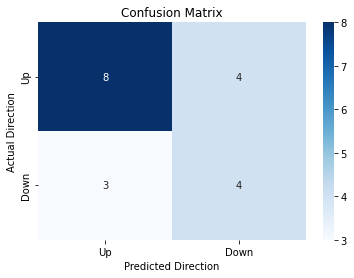

              precision    recall  f1-score   support

          Up       0.73      0.67      0.70        12
        Down       0.50      0.57      0.53         7

    accuracy                           0.63        19
   macro avg       0.61      0.62      0.61        19
weighted avg       0.64      0.63      0.64        19



In [47]:
result= pd.read_csv("C:/Dissertation/ML Codes Final/ML Output/eth_op.csv")
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report


report = classification_report(result['Actual_Direction'], result['Predicted_Direction'], labels=['Up', 'Down'])
cm = confusion_matrix(result['Actual_Direction'], result['Predicted_Direction'], labels=['Up', 'Down'])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Up', 'Down'], yticklabels=['Up', 'Down'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Direction")
plt.ylabel("Actual Direction")
plt.show()
print(report)